In [0]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from skimage import io, color
from sklearn import metrics

import time
import os
import pickle

import matplotlib.pyplot as plt
#import scikitplot as skplt

In [0]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1080


# Model-GoogLeNet

In [0]:
googlenet = models.googlenet(pretrained=True)
googlenet = models.googlenet(num_classes=3)
googlenet.aux_logits = False

In [0]:
root_dir = '/home/yz6121/dl/data/data/'
model = googlenet.to(device)
model.load_state_dict(torch.load(root_dir+'best_3class1.pth'))
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

# Data loading

In [0]:

train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([364, 364]),
        transforms.RandomResizedCrop(320),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

validation_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([364,364]),
        transforms.CenterCrop(320),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [0]:
class ChestXray(Dataset):

    def __init__(self, csv_file, image_root_dir, transform=None):

        self.data_frame = pd.read_csv(csv_file)
        self.image_root_dir = image_root_dir
        self.image_path = self.data_frame['image_index']
        self.transform = transform
        
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, index):
        image_filename = self.image_root_dir + self.image_path[index]
        image = io.imread(image_filename, as_gray=True)
        
        sample = {}
        
        # need to transpose: input size for ToPILImage() is H*W*C not C*H*W
        image = np.repeat(image[None,...], 3, axis=0).transpose(1, 2, 0)
        
        if self.transform:
            image = self.transform(np.uint8(image))

        sample['image'] = image
        
        label_col_names = ['normal', 'pneumonia']
        
        sample['label'] = torch.LongTensor([self.data_frame['label'][index]])
        
        return sample

In [0]:
def train(model, optimizer, criterion, loader, device):
    
    model.train()

    running_loss = 0.0
    epoch_loss = 0.0
    total_samples = 0
    correct = 0 

    for batch_idx, samples in enumerate(loader):
        
        image = samples['image'].to(device)
        label = samples['label'].squeeze()
        label = torch.tensor(label, dtype=torch.long, device=device)
        
        preds = model(image)        
        
        loss = train_criterion(preds, label)
        running_loss += loss.item()
        epoch_loss += loss.item()
        
        total_samples += image.shape[0]
        correct += torch.sum(torch.max(preds, dim=1)[1] == label).item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss = 0.0

    training_accuracy = correct / total_samples

    return epoch_loss / len(loader), training_accuracy

In [0]:
#new
def validation(model, optimizer, criterion, loader, device):

    model.eval( )

    running_loss = 0.0
    total_samples = 0
    correct = 0
    mysoftmax = nn.Softmax(dim=1)

    preds_list = []
    truelabels_list = []
    probas_list = []

    with torch.no_grad():
        for batch_idx, samples in enumerate(loader):

            image = samples['image'].to(device)
            label = samples['label'].squeeze()
            label = torch.tensor(label, dtype=torch.long, device=device)

            output = model(image)
            output_softmax = mysoftmax(output)

            _, preds = torch.max(output, dim = 1)

            loss = criterion(output, label)
            running_loss += loss.item()

            total_samples += image.shape[0]
            correct += torch.sum(preds == label).item()

            preds_list.append(preds.cpu().numpy())
            truelabels_list.append(label.cpu().numpy())
            probas_list.append(output_softmax.cpu().numpy())

        valid_accuracy = correct / total_samples

        probas_list = np.vstack(probas_list)
        truelabels_list = np.concatenate(truelabels_list)
        preds_list = np.concatenate(preds_list)

        #auc_score = metrics.roc_auc_score(truelabels_list, preds_list, multi_class = 'ovo')

        return running_loss / len(loader), valid_accuracy, preds_list, truelabels_list, probas_list

In [0]:
train_df_path = '/home/yz6121/dl/data/data/train_3.csv'
val_df_path = '/home/yz6121/dl/data/data/val_3.csv'
root_dir = '/home/yz6121/dl/data/data/'

bs = 10
#epochs = 10

train_loader = DataLoader(ChestXray(train_df_path, root_dir, transform=train_transform), batch_size=bs, shuffle=True)
valid_loader = DataLoader(ChestXray(val_df_path, root_dir, transform=validation_transform), batch_size=bs, shuffle=False)    
                                                         
#model = googlenet

#model.to(device)

# weighted cross entropy loss: normal, pneumonia
train_weights = train_loader.dataset.data_frame.shape[0] / np.array(train_loader.dataset.data_frame['class'].value_counts())[::-1]
valid_weights = valid_loader.dataset.data_frame.shape[0] / np.array(valid_loader.dataset.data_frame['class'].value_counts())[::-1]

train_weights = torch.FloatTensor(train_weights).to(device)
valid_weights = torch.FloatTensor(valid_weights).to(device)

train_criterion = nn.CrossEntropyLoss(weight=train_weights)
valid_criterion = nn.CrossEntropyLoss(weight=valid_weights)


optimizer = optim.Adam(model.parameters(),lr = 0.001)

criterions = []

#history = {"train_loss":[], "train_acc":[], "valid_loss":[], "valid_acc":[]}

#best_val_loss = np.inf



In [0]:
with open("history_3class1.pkl", 'rb') as fo:
    history_gn2 = pickle.load(fo, encoding='bytes')
#print(history_gn1)

In [0]:
print(len(history_gn1['train_loss']))

88


In [0]:
history = {"train_loss":[], "train_acc":[],
           "valid_loss":[], "valid_acc":[]}

In [0]:
from numpy import *
def train_gn(epochs, model, optimizer, train_criterion, train_loader, valid_criterion, valid_loader, device):
    #model.to(device)
    history = history_gn1
    #history = {"train_loss":[], "train_acc":[],
           #"valid_loss":[], "valid_acc":[], "valid_preds_list":[],
           #"valid_truelabels_list":[], "valid_probas_list":[]}
    #history = {"train_loss":[], "train_acc":[], "valid_loss":[], "valid_acc":[]}
    best_acc = max(history['valid_acc'])
    since = time.time()
    for epoch in range(epochs): 
        print('Epoch: {}/{}'.format(epoch, epochs-1))
        print('-'*10)
        #train
        train_loss, train_acc = train(model, optimizer, train_criterion, train_loader, device)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f}'.format('train', train_loss, train_acc))

        #validation
        valid_loss, valid_acc, valid_preds_list, valid_truelabels_list, valid_probas_list = validation(model, optimizer, valid_criterion, valid_loader, device)
        history["valid_loss"].append(valid_loss)
        history["valid_acc"].append(valid_acc)
        history["valid_preds_list"].append(valid_preds_list)
        history["valid_truelabels_list"].append(valid_truelabels_list)
        history["valid_probas_list"].append(valid_probas_list)
        #history["valid_auc_score"].append(valid_auc_score)
        
        
        #valid_loss, valid_acc = validation(model, optimizer, valid_criterion, valid_loader, device) #, append_line_to_log)
        #history["valid_loss"].append(valid_loss)
        #history["valid_acc"].append(valid_acc)
        
        print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f}'.format('validation', valid_loss, valid_acc))

        #save model
        if valid_acc>best_acc:
            best_acc = valid_acc
            best_model_file = root_dir + "best_3class1.pth"
            torch.save(model.state_dict(), best_model_file)
            best_model_wts = model.state_dict()

        if epoch%5 == 0:
            with open("history_3class1.pkl", "wb") as fout:
                pickle.dump(history, fout)
        if abs(mean(history['train_loss'][:-10])-history['train_loss'][-1])<0.005:
            break



    model.load_state_dict(best_model_wts)

    #save loss/acc
    if epoch == epochs - 1:
        with open("history_3class1.pkl", "wb") as fout:
            pickle.dump(history, fout)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model, history

    

In [0]:
#googlenet: train the first 20 epochs
epochs = 20

model_gn2, history_gn2 = train_gn(epochs, model, optimizer, train_criterion, train_loader, valid_criterion, valid_loader, device)

Epoch: 0/19
----------


<ipython-input-11-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.5809 Acc: 0.7395


<ipython-input-12-aac8991379b9>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.4260 Acc: 0.8662
Epoch: 1/19
----------
Phase:train, epoch loss: 0.5590 Acc: 0.7481
Phase:validation, epoch loss: 0.4504 Acc: 0.8567
Epoch: 2/19
----------
Phase:train, epoch loss: 0.5829 Acc: 0.7389
Phase:validation, epoch loss: 0.4220 Acc: 0.8885
Epoch: 3/19
----------
Phase:train, epoch loss: 0.5640 Acc: 0.7408
Phase:validation, epoch loss: 0.4548 Acc: 0.8726
Epoch: 4/19
----------
Phase:train, epoch loss: 0.5775 Acc: 0.7395
Phase:validation, epoch loss: 0.4403 Acc: 0.8599
Epoch: 5/19
----------
Phase:train, epoch loss: 0.5649 Acc: 0.7412
Phase:validation, epoch loss: 0.3221 Acc: 0.9013
Epoch: 6/19
----------
Phase:train, epoch loss: 0.5749 Acc: 0.7445
Phase:validation, epoch loss: 0.4759 Acc: 0.8535
Epoch: 7/19
----------
Phase:train, epoch loss: 0.5737 Acc: 0.7475
Phase:validation, epoch loss: 0.5450 Acc: 0.8631
Epoch: 8/19
----------
Phase:train, epoch loss: 0.5718 Acc: 0.7353
Phase:validation, epoch loss: 0.5320 Acc: 0.8535
Epoch: 9/19
----------


UnboundLocalError: local variable 'best_model_wts' referenced before assignment

In [0]:
#googlenet: train the first 20 epochs
epochs = 50

model_gn2, history_gn2 = train_gn(epochs, model, optimizer, train_criterion, train_loader, valid_criterion, valid_loader, device)

Epoch: 0/49
----------


<ipython-input-7-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.5929 Acc: 0.7309


<ipython-input-8-aac8991379b9>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.4097 Acc: 0.8726
Epoch: 1/49
----------
Phase:train, epoch loss: 0.5978 Acc: 0.7324
Phase:validation, epoch loss: 0.3884 Acc: 0.8885
Epoch: 2/49
----------
Phase:train, epoch loss: 0.5902 Acc: 0.7351
Phase:validation, epoch loss: 0.3556 Acc: 0.9108
Epoch: 3/49
----------
Phase:train, epoch loss: 0.5864 Acc: 0.7297
Phase:validation, epoch loss: 0.5134 Acc: 0.8822
Epoch: 4/49
----------
Phase:train, epoch loss: 0.5752 Acc: 0.7408
Phase:validation, epoch loss: 0.6458 Acc: 0.8121
Epoch: 5/49
----------
Phase:train, epoch loss: 0.5836 Acc: 0.7372
Phase:validation, epoch loss: 0.6513 Acc: 0.7389
Epoch: 6/49
----------
Phase:train, epoch loss: 0.5828 Acc: 0.7393
Phase:validation, epoch loss: 0.5489 Acc: 0.8280
Epoch: 7/49
----------
Phase:train, epoch loss: 0.5866 Acc: 0.7381
Phase:validation, epoch loss: 0.4968 Acc: 0.8439
Epoch: 8/49
----------
Phase:train, epoch loss: 0.5710 Acc: 0.7483
Phase:validation, epoch loss: 0.3232 Acc: 0.9045
Epoch: 9/49
----------


In [0]:
#googlenet: train the first 20 epochs
epochs = 100

model_gn1, history_gn1 = train_gn(epochs, model, optimizer, train_criterion, train_loader, valid_criterion, valid_loader, device)

Epoch: 0/99
----------


<ipython-input-16-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.9814 Acc: 0.5208


<ipython-input-17-aac8991379b9>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.9204 Acc: 0.5605
Epoch: 1/99
----------
Phase:train, epoch loss: 0.9039 Acc: 0.5346
Phase:validation, epoch loss: 0.7183 Acc: 0.7038
Epoch: 2/99
----------
Phase:train, epoch loss: 0.8462 Acc: 0.6015
Phase:validation, epoch loss: 0.7479 Acc: 0.5987
Epoch: 3/99
----------
Phase:train, epoch loss: 0.8292 Acc: 0.5948
Phase:validation, epoch loss: 1.5578 Acc: 0.4108
Epoch: 4/99
----------
Phase:train, epoch loss: 0.8482 Acc: 0.5910
Phase:validation, epoch loss: 0.8150 Acc: 0.6624
Epoch: 5/99
----------
Phase:train, epoch loss: 0.8166 Acc: 0.6038
Phase:validation, epoch loss: 1.0286 Acc: 0.5350
Epoch: 6/99
----------
Phase:train, epoch loss: 0.7958 Acc: 0.6153
Phase:validation, epoch loss: 0.8046 Acc: 0.6879
Epoch: 7/99
----------
Phase:train, epoch loss: 0.7889 Acc: 0.6239
Phase:validation, epoch loss: 0.8341 Acc: 0.5510
Epoch: 8/99
----------
Phase:train, epoch loss: 0.7680 Acc: 0.6317
Phase:validation, epoch loss: 0.6693 Acc: 0.7420
Epoch: 9/99
----------


In [0]:
#googlenet: train the first 20 epochs
epochs = 50

model_gn2, history_gn2 = train_gn(epochs, model, optimizer, train_criterion, train_loader, valid_criterion, valid_loader, device)

Epoch: 0/49
----------


<ipython-input-11-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.6458 Acc: 0.7034


<ipython-input-26-aac8991379b9>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.6029 Acc: 0.8057
Epoch: 1/49
----------
Phase:train, epoch loss: 0.6455 Acc: 0.7076
Phase:validation, epoch loss: 0.7310 Acc: 0.7611
Epoch: 2/49
----------
Phase:train, epoch loss: 0.6410 Acc: 0.7089
Phase:validation, epoch loss: 0.5660 Acc: 0.8217
Epoch: 3/49
----------
Phase:train, epoch loss: 0.6433 Acc: 0.7058
Phase:validation, epoch loss: 0.6364 Acc: 0.7962
Epoch: 4/49
----------
Phase:train, epoch loss: 0.6304 Acc: 0.7122
Phase:validation, epoch loss: 0.5728 Acc: 0.8089
Epoch: 5/49
----------
Phase:train, epoch loss: 0.6317 Acc: 0.7102
Phase:validation, epoch loss: 0.5747 Acc: 0.8248
Epoch: 6/49
----------
Phase:train, epoch loss: 0.6203 Acc: 0.7143
Phase:validation, epoch loss: 0.4711 Acc: 0.8535
Epoch: 7/49
----------
Phase:train, epoch loss: 0.6255 Acc: 0.7160
Phase:validation, epoch loss: 0.5765 Acc: 0.8121
Epoch: 8/49
----------
Phase:train, epoch loss: 0.6316 Acc: 0.7198
Phase:validation, epoch loss: 0.6934 Acc: 0.7930
Epoch: 9/49
----------


In [0]:
#googlenet: train the first 20 epochs
epochs = 20

model_gn1, history_gn1 = train_gn(epochs, model, optimizer, train_criterion, train_loader, valid_criterion, valid_loader, device)

Epoch: 0/19
----------


<ipython-input-11-435d693a1836>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:train, epoch loss: 0.8102 Acc: 0.6003


<ipython-input-26-aac8991379b9>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


Phase:validation, epoch loss: 0.7037 Acc: 0.7389
Epoch: 1/19
----------
Phase:train, epoch loss: 0.8023 Acc: 0.6206
Phase:validation, epoch loss: 0.9456 Acc: 0.5637
Epoch: 2/19
----------
Phase:train, epoch loss: 0.7871 Acc: 0.6305
Phase:validation, epoch loss: 0.8882 Acc: 0.6783
Epoch: 3/19
----------
Phase:train, epoch loss: 0.7822 Acc: 0.6307
Phase:validation, epoch loss: 0.6915 Acc: 0.7102
Epoch: 4/19
----------
Phase:train, epoch loss: 0.7603 Acc: 0.6453
Phase:validation, epoch loss: 0.6561 Acc: 0.7357
Epoch: 5/19
----------
Phase:train, epoch loss: 0.7500 Acc: 0.6428
Phase:validation, epoch loss: 0.7217 Acc: 0.6720
Epoch: 6/19
----------
Phase:train, epoch loss: 0.7498 Acc: 0.6502
Phase:validation, epoch loss: 0.8294 Acc: 0.7261
Epoch: 7/19
----------
Phase:train, epoch loss: 0.7368 Acc: 0.6590
Phase:validation, epoch loss: 0.9365 Acc: 0.6688
Epoch: 8/19
----------
Phase:train, epoch loss: 0.7231 Acc: 0.6619
Phase:validation, epoch loss: 0.6830 Acc: 0.7548
Epoch: 9/19
----------


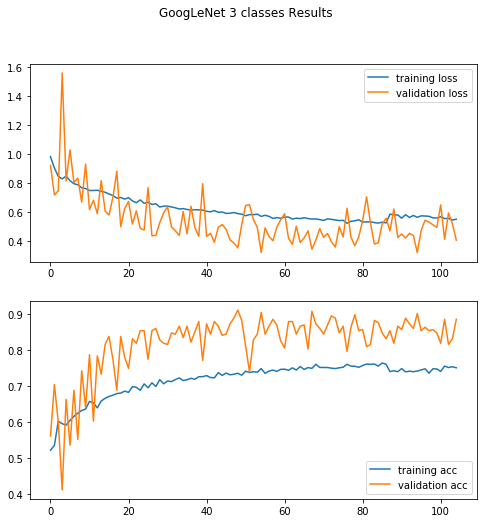

In [0]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))
fig.suptitle('GoogLeNet 3 classes Results')

ax1.plot(history_gn2['train_loss'], label='training loss')
ax1.plot(history_gn2['valid_loss'], label='validation loss')
ax1.legend()

ax2.plot(history_gn2['train_acc'], label='training acc')
ax2.plot(history_gn2['valid_acc'], label='validation acc')
ax2.legend()

#ax3.plot(history_gn1['valid_auc_score'], label='valid auc score')
#ax3.legend()

plt.savefig('GoogLeNet_3classestrain.jpeg')

In [0]:
# for test only
test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([364,364]),
        transforms.CenterCrop(320),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
root_dir = '/home/yz6121/dl/data/data/'

test_df_path = '/home/yz6121/dl/data/data/test_3.csv'

bs=10

test_loader = DataLoader(ChestXray(test_df_path, root_dir, transform=test_transform), batch_size=bs, shuffle=False)    

test_weights = test_loader.dataset.data_frame.shape[0] / np.array(test_loader.dataset.data_frame['class'].value_counts())[::-1]
test_weights = torch.FloatTensor(test_weights).to(device)
test_criterion = nn.CrossEntropyLoss(weight=test_weights)

optimizer = optim.Adam(model.parameters())

In [0]:
def test(model, optimizer, criterion, loader, device):

    model.eval()

    running_loss = 0.0
    total_samples = 0
    correct = 0
    mysoftmax = nn.Softmax(dim=1)

    preds_list = []
    truelabels_list = []
    probas_list = []
    with torch.no_grad():
        for batch_idx, samples in enumerate(loader):

            image = samples['image'].to(device)
            label = samples['label'].squeeze()
            label = torch.tensor(label, dtype=torch.long, device=device)

            output = model(image)
            output_softmax = mysoftmax(output)

            _, preds = torch.max(output, dim = 1)

            loss = test_criterion(output, label)
            running_loss += loss.item()

            total_samples += image.shape[0]
            correct += torch.sum(preds == label).item()


            preds_list.append(preds.cpu().numpy())
            truelabels_list.append(label.cpu().numpy())
            probas_list.append(output_softmax.cpu().numpy())

        test_accuracy = correct / total_samples

        return running_loss / len(loader), test_accuracy, preds_list, truelabels_list, probas_list


In [0]:
#val
history_googlenet_valid = {"valid_loss":[], "valid_acc":[], "preds_list":[], "truelabels_list":[], "proabs_list":[]}

valid_loss, valid_acc, preds_list, truelabels_list, proabs_list= test(model, optimizer, valid_criterion, valid_loader, device)
history_googlenet_valid["valid_loss"].append(valid_loss)
history_googlenet_valid["valid_acc"].append(valid_acc)
history_googlenet_valid["preds_list"].append(preds_list)
history_googlenet_valid["truelabels_list"].append(truelabels_list)
history_googlenet_valid["proabs_list"].append(proabs_list)

print('{}: valid loss: {:.4f} Acc: {:.4f}'.format('validation', valid_loss, valid_acc))
print()

<ipython-input-14-7747a6347df9>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long, device=device)


validation: valid loss: 0.3319 Acc: 0.8981



# Evaluation on validation set

In [0]:
from torch.autograd import Variable
def inference(model_ft,loader):
    use_gpu = 1
    model_ft.eval()
    whole_output =[]
    whole_target = []

    for valData in loader:
        data = valData['image']
        target = valData['label']
        if use_gpu:
            data = Variable(data,volatile=True).type(torch.FloatTensor).cuda()
            target = Variable(target,volatile=True).type(torch.LongTensor).cuda()
        else:
            data, target = Variable(data,volatile=True).type(torch.FloatTensor), Variable(target,volatile=True).type(torch.LongTensor)

        output =F.softmax(model_ft(data),dim=1)
        whole_output.append( output.cpu().data.numpy())
        whole_target.append( valData['label'].numpy())

    whole_output = np.concatenate(whole_output)
    whole_target = np.concatenate(whole_target)

    y_score = whole_output
    y_target = label_binarize(whole_target, classes=[0, 1, 2])
    
    return y_score, y_target

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

def get_AUC(y_score, y_target,plotROC=False):
    n_classes = y_score.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_target[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_target.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    if plotROC:
        lw = 2
        # Plot all ROC curves
        plt.figure()
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))
            
        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('GoogLeNet(3 classes) ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

    return roc_auc

<ipython-input-19-02bc424a3bc6>:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data,volatile=True).type(torch.FloatTensor).cuda()
<ipython-input-19-02bc424a3bc6>:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  target = Variable(target,volatile=True).type(torch.LongTensor).cuda()
<ipython-input-20-8e390c3db6b2>:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


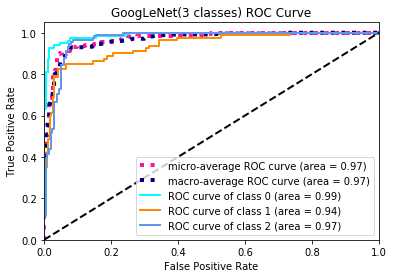

macro AUC for GoogLeNet is:  0.9669068808681136


In [0]:
#val
y_s, y_t=inference(model,valid_loader)
r_AUC = get_AUC(y_s, y_t, True)
print('macro AUC for GoogLeNet is: ', r_AUC["macro"])

In [0]:
with open("history_3class1_test.pkl", "wb") as fout:
    pickle.dump(history_resnet_test, fout)

In [0]:
proabs_stacked = np.vstack(proabs_list)
true_labels = np.concatenate(truelabels_list)
pred_labels = np.concatenate(preds_list)

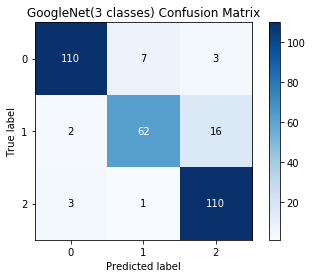

In [0]:
#val new
import scikitplot as skplt
#skplt.metrics.plot_roc(true_labels, proabs_stacked)
skplt.metrics.plot_confusion_matrix(true_labels, pred_labels, title = 'GoogleNet(3 classes) Confusion Matrix')